In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/facebook-recruiting-iii-keyword-extraction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
/kaggle/input/facebook-recruiting-iii-keyword-extraction/SampleSubmission.csv
/kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip


In [2]:
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

In [3]:
!unzip /kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip 
!unzip /kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip

Archive:  /kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
  inflating: Train.csv               
Archive:  /kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip
  inflating: Test.csv                


In [4]:
df_train = pd.read_csv('/kaggle/working/Train.csv' ,nrows=10000)
df_train.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [5]:
print('shape pof dataframe is: ',df_train.shape)

shape pof dataframe is:  (10000, 4)


In [6]:
df_train.isna().sum()

Id       0
Title    0
Body     0
Tags     0
dtype: int64

In [7]:
df_train.drop_duplicates(subset=['Title','Body','Tags'],inplace =True)
df_train.reset_index(drop = True,inplace=True)

In [8]:
df_train.shape

(9997, 4)

In [9]:
df_train['Tag_count'] = df_train['Tags'].apply(lambda x : len(x.split()))

In [10]:
df_train.head()

,Id,Title,Body,Tags,Tag_count
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents,3


In [11]:
df_train['Tag_count'].value_counts()

3    2919
2    2612
4    1969
1    1296
5    1201
Name: Tag_count, dtype: int64

In [12]:
print( "Maximum number of tags in a question: ", df_train["Tag_count"].max())
print( "Minimum number of tags in a question: ", df_train["Tag_count"].min())
print( "Average number of tags in a question: ", df_train["Tag_count"].mean())

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  2.9166750025007504


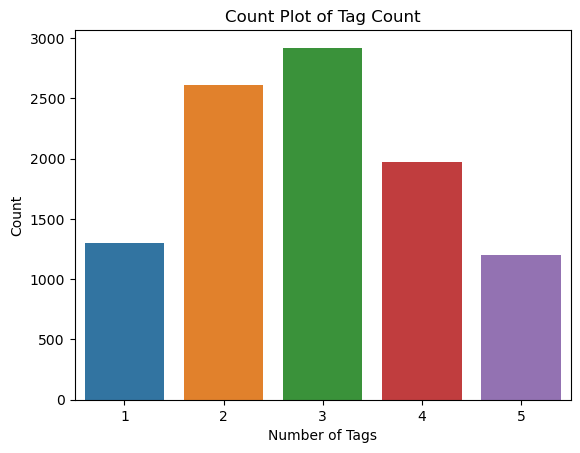

In [13]:
sns.countplot(data=df_train, x='Tag_count')
plt.xlabel('Number of Tags')
plt.ylabel('Count')
plt.title('Count Plot of Tag Count')

# Show the plot
plt.show()


In [14]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_bow = vectorizer.fit_transform(df_train['Tags'])

In [15]:
print("Number of questions :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

Number of questions : 9997
Number of unique tags : 6124


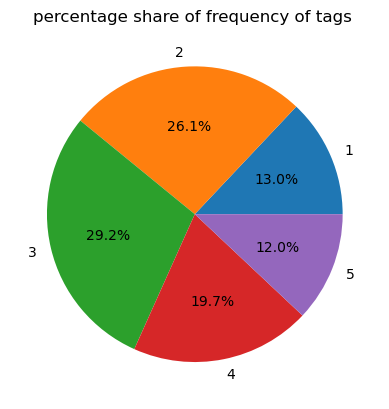

In [16]:
tag_count_freq = df_train['Tag_count'].value_counts().sort_index()
plt.pie(tag_count_freq , labels =tag_count_freq.index , autopct='%1.1f%%')
plt.title("percentage share of frequency of tags ")
plt.show()

In [17]:
tags = vectorizer.get_feature_names_out()
print("Some of the tags are :", tags[:10])

Some of the tags are : ['.htaccess' '.net' '.net-2.0' '.net-3.5' '.net-4.0' '.net-4.5'
 '.net-assembly' '.net-framework' '.net4.0' '.refresh']


In [18]:
freq = tag_bow.sum(axis=0).A1
tag_to_count_map = dict(zip(tags, freq))

In [19]:
list = []
for key, value in tag_to_count_map.items():
  list.append([key, value]) 

In [20]:
tag_df = pd.DataFrame(list, columns=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.htaccess,40
1,.net,302
2,.net-2.0,6
3,.net-3.5,7
4,.net-4.0,10


Text(0, 0.5, 'Frequency')

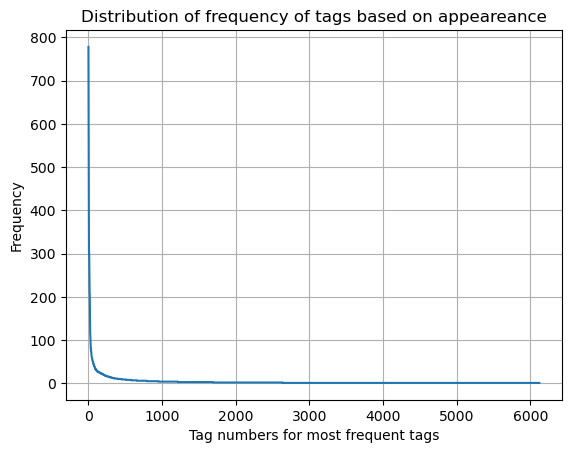

In [21]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
plt.plot(tag_df_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

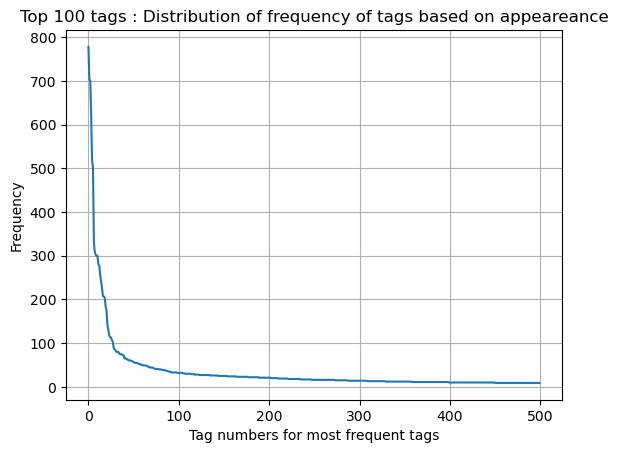

In [22]:
plt.plot(tag_df_sorted['Counts'][0:500].values)
plt.grid()
plt.title("Top 100 tags : Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

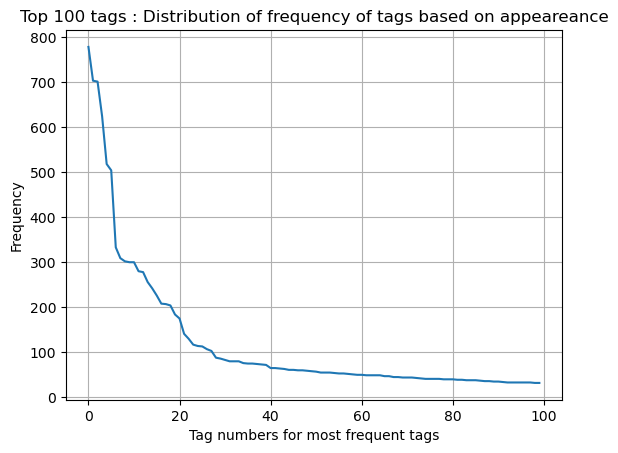

In [23]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.grid()
plt.title("Top 100 tags : Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

In [24]:
most_used_tags = tag_df_sorted.nlargest(20,'Counts')
print(most_used_tags)

               Tags  Counts
674              c#     778
2666           java     703
3937            php     701
2685     javascript     624
179         android     518
2760         jquery     504
678             c++     333
345         asp.net     309
1              .net     302
4212         python     300
2608         iphone     300
2340           html     280
3434          mysql     278
4928            sql     256
2594            ios     242
1130            css     226
2968          linux     208
4536  ruby-on-rails     207
3641    objective-c     204
673               c     184


In [25]:
print("{} tags are used more than 100times".format(tag_df_sorted[tag_df_sorted["Counts"]>100].shape[0]))
print("{} tags are used more than 300 times".format(tag_df_sorted[tag_df_sorted["Counts"]>300].shape[0]))
print("{} tags are used more than 500 times".format(tag_df_sorted[tag_df_sorted["Counts"]>500].shape[0]))

28 tags are used more than 100times
9 tags are used more than 300 times
6 tags are used more than 500 times


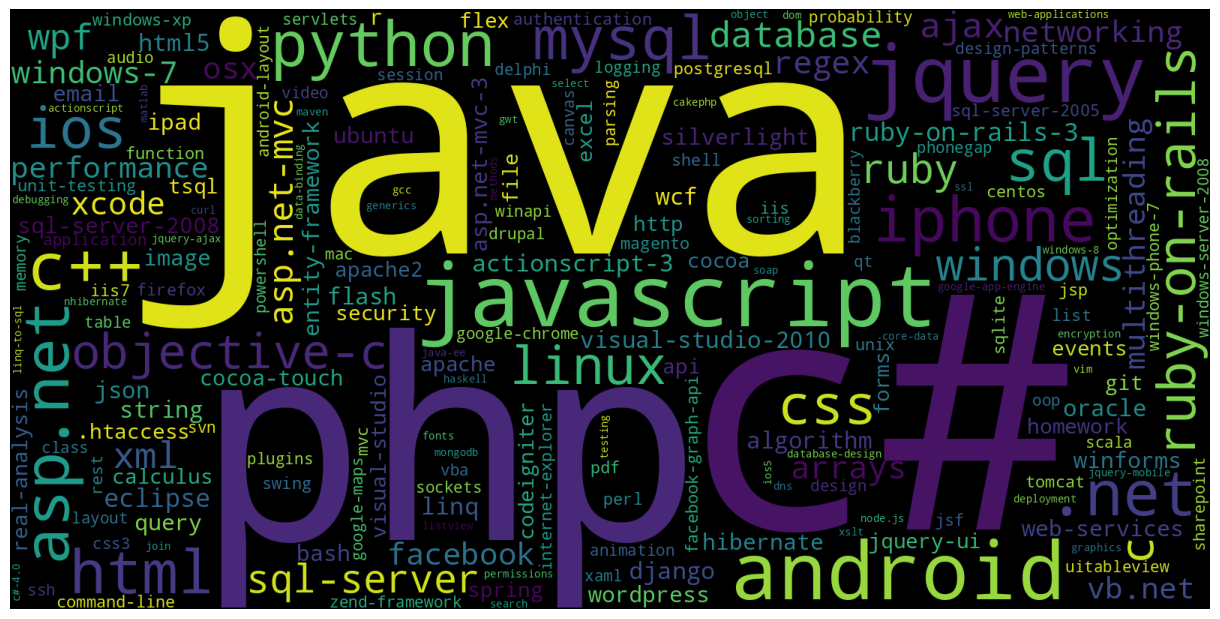

In [26]:
tag_to_count_map
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

<Figure size 1000x600 with 0 Axes>

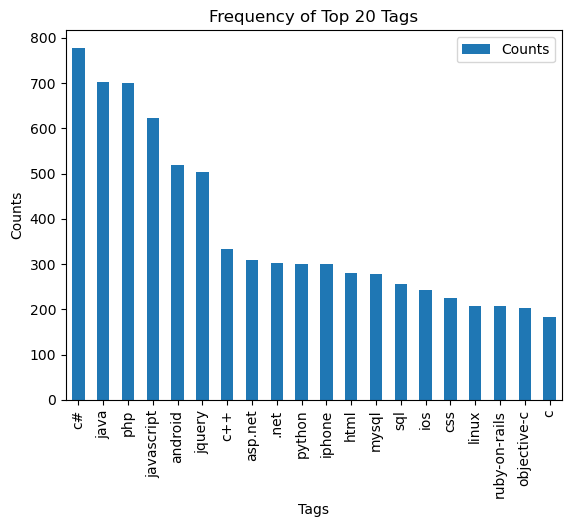

In [27]:
top_20_tags = tag_df_sorted.head(20)
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size
top_20_tags.plot(kind='bar')
plt.title('Frequency of Top 20 Tags')
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.xticks(range(len(top_20_tags)), top_20_tags['Tags'], rotation='vertical')
plt.show()


In [28]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [29]:
qus_list=[]
qus_with_code = 0
len_before_preprocessing = 0 
len_after_preprocessing = 0 
for index,row in df_train.iterrows():
    title, body, tags = row["Title"], row["Body"], row["Tags"]
    if '<code>' in body:
        qus_with_code+=1
    len_before_preprocessing+=len(title) + len(body)
    body=re.sub('<code>(.*?)</code>', '', body, flags=re.MULTILINE|re.DOTALL)
    body = re.sub('<.*?>', ' ', str(body.encode('utf-8')))
    title=title.encode('utf-8')
    question=str(title)+" "+str(body)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    qus_list.append(question)
    len_after_preprocessing += len(question)
df_train["question"] = qus_list
avg_len_before_preprocessing=(len_before_preprocessing*1.0)/df_train.shape[0]
avg_len_after_preprocessing=(len_after_preprocessing*1.0)/df_train.shape[0]
print( "Avg. length of questions(Title+Body) before preprocessing: ", avg_len_before_preprocessing)
print( "Avg. length of questions(Title+Body) after preprocessing: ", avg_len_after_preprocessing)
print ("% of questions containing code: ", (qus_with_code*100.0)/df_train.shape[0])


Avg. length of questions(Title+Body) before preprocessing:  1158.5306591977594
Avg. length of questions(Title+Body) after preprocessing:  329.37541262378716
% of questions containing code:  55.886766029808946


In [30]:
preprocessed_train_df = df_train[["question","Tags"]]
print("Shape of preprocessed data :", preprocessed_train_df.shape)

Shape of preprocessed data : (9997, 2)


In [31]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=True)
y_multilabel = vectorizer.fit_transform(preprocessed_train_df['Tags'])


In [32]:
def tags_to_consider(n):
    tag_i_sum = y_multilabel.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(tag_i_sum)), key=lambda i: tag_i_sum[i], reverse=True)
    yn_multilabel=y_multilabel[:,sorted_tags_i[:n]]
    return yn_multilabel

def questions_covered_fn(numb):
    yn_multilabel = tags_to_consider(numb)
    x= yn_multilabel.sum(axis=1)
    return (np.count_nonzero(x==0))

In [33]:
questions_covered = []
total_tags=y_multilabel.shape[1]
total_qus=preprocessed_train_df.shape[0]
for i in range(400, total_tags, 500):
    questions_covered.append(np.round(((total_qus-questions_covered_fn(i))/total_qus)*100,3))

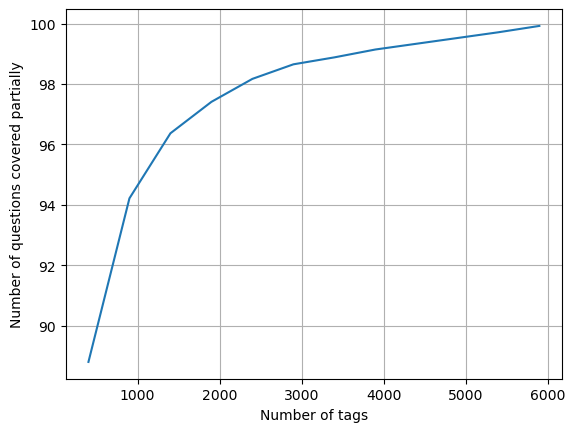

99.52 % of questions covered by 4000 tags
Number of questions that are not covered by 100 tags :  81 out of  9997


In [34]:
plt.plot(np.arange(400,total_tags, 500),questions_covered)
plt.xlabel("Number of tags")
plt.ylabel("Number of questions covered partially")
plt.grid()
plt.show()
print(questions_covered[9],"% of questions covered by 4000 tags")
print("Number of questions that are not covered by 100 tags : ", questions_covered_fn(4000),"out of ", total_qus)

In [35]:
yx_multilabel = tags_to_consider(4000)
print("Number of tags in the subset :", y_multilabel.shape[1])
print("Number of tags considered :", yx_multilabel.shape[1],"(",(yx_multilabel.shape[1]/y_multilabel.shape[1])*100,"%)")

Number of tags in the subset : 6124
Number of tags considered : 4000 ( 65.31678641410844 %)


In [36]:
preprocessed_train_df.head()

,question,Tags
0,check upload file imag without mime type like ...,php image-processing file-upload upload mime-t...
1,prevent firefox close press ctrl favorit edito...,firefox
2,error invalid type list variabl import matlab ...,r matlab machine-learning
3,replac special charact url probabl simpl simpl...,c# url encoding
4,modifi whoi contact detail use modifi function...,php api file-get-contents


In [37]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_train_df, yx_multilabel, test_size = 0.2,random_state = 42)
print("Number of data points in training data :", X_train.shape[0])
print("Number of data points in test data :", X_test.shape[0])

Number of data points in training data : 7997
Number of data points in test data : 2000


In [38]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train['question'])
X_test_multilabel = vectorizer.transform(X_test['question'])

In [39]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))
clf.fit(X_train_multilabel, y_train)
y_pred = clf.predict(X_test_multilabel)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.0465
Macro f1 score : 0.009636920235048418
Micro f1 scoore : 0.21064336775218426
Hamming loss : 0.000621125


In [ ]:
# clf2 = OneVsRestClassifier(LogisticRegression(penalty='l2'))
# clf2.fit(X_train_multilabel, y_train)
# y_pred2 = clf2.predict(X_test_multilabel)

In [ ]:
# print("Accuracy :",metrics.accuracy_score(y_test,y_pred2))
# print("Macro f1 score :",metrics.f1_score(y_test, y_pred2, average = 'macro'))
# print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred2, average = 'micro'))
# print("Hamming loss :",metrics.hamming_loss(y_test,y_pred2))